<a href="https://colab.research.google.com/github/sayan0506/Task-2-Internship/blob/main/IIITD_assignment_task_2_test_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Training Central Dataset**

Assignment link: 

https://docs.google.com/document/d/1WQHJ2KpImvA1l5QOkLQjaECOSKMiT3jp_UKH2p1zk_c/edit

In [31]:
# install keras livelossplot
!pip -q install livelossplot

# install wandb
!pip install --upgrade wandb

Requirement already up-to-date: wandb in /usr/local/lib/python3.7/dist-packages (0.10.25)


# **Import Modules**

In [110]:
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd

import tensorflow as tf
import keras
from keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

from livelossplot import PlotLossesKeras
from keras.models import model_from_json

from sklearn import metrics
from sklearn.metrics import confusion_matrix

# **Environment Setup**
**Improve Reproducibility**

In [33]:
# improve reproducibility and make it more deterministic
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by rmoving stochasticity")% 2**32 -1)

**Setup wandb environment**

In [34]:
import wandb
from wandb.keras import WandbCallback

# authorize
# wandb.login()

# **Section 1**

# **Download and unzipping the Dataset**

[Dropbox dataset link](https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip)

In [35]:
!wget https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip

--2021-04-09 16:08:08--  https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/pan6mutc5xj5kj0/trainPart1.zip [following]
--2021-04-09 16:08:08--  https://www.dropbox.com/s/raw/pan6mutc5xj5kj0/trainPart1.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2a4854bc32ed3f9060316d5c65.dl.dropboxusercontent.com/cd/0/inline/BMQ45MR3VZkYz7vrMv9bI8KCSXOlwcm_jHhMkWXebnKxWQfzMvrbAkscNFRqTyYuZ6qjGoy-ltgtTyrHUneJrcSTA1CWcl3E7cpEWr_sUCcKCpLr_WNgH0r-jUcyFVafdal8G5BgciRBOPFbztXXC3vD/file# [following]
--2021-04-09 16:08:09--  https://uc2a4854bc32ed3f9060316d5c65.dl.dropboxusercontent.com/cd/0/inline/BMQ45MR3VZkYz7vrMv9bI8KCSXOlwcm_jHhMkWXebnKxWQfzMvrbAkscNFRqTyYuZ6qjGoy-ltgtTyrHUneJ

## Unzipping

In [36]:
# defining unzipping function
def unzip(zip_file, content_dir):
  if not os.path.isdir(content_dir):
    os.mkdir(content_dir)

  # unzipping
  with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(content_dir)

In [37]:
# zipfile path
zip_file = '/content/trainPart1.zip'

# content directory
content_dir = 'master_data'

# calling unzip
unzip(zip_file, content_dir)

# **Data Inspection**

In [38]:
# master directory path
img_dir = '/content/master_data/train'

# classifiers list
print(f'List of classifiers\n{sorted(os.listdir(img_dir))}')
print(f'Total {len(os.listdir(img_dir))} classifiers are there')


List of classifiers
['Sample001', 'Sample002', 'Sample003', 'Sample004', 'Sample005', 'Sample006', 'Sample007', 'Sample008', 'Sample009', 'Sample010', 'Sample011', 'Sample012', 'Sample013', 'Sample014', 'Sample015', 'Sample016', 'Sample017', 'Sample018', 'Sample019', 'Sample020', 'Sample021', 'Sample022', 'Sample023', 'Sample024', 'Sample025', 'Sample026', 'Sample027', 'Sample028', 'Sample029', 'Sample030', 'Sample031', 'Sample032', 'Sample033', 'Sample034', 'Sample035', 'Sample036', 'Sample037', 'Sample038', 'Sample039', 'Sample040', 'Sample041', 'Sample042', 'Sample043', 'Sample044', 'Sample045', 'Sample046', 'Sample047', 'Sample048', 'Sample049', 'Sample050', 'Sample051', 'Sample052', 'Sample053', 'Sample054', 'Sample055', 'Sample056', 'Sample057', 'Sample058', 'Sample059', 'Sample060', 'Sample061', 'Sample062']
Total 62 classifiers are there


## Defining the classifiers

From the dataset we are adding custom labels to the classifiers. We find that each of the individual folder consist of unique classes.

In [39]:
class_ids = [int(id.split('Sample')[1]) for id in sorted(os.listdir(img_dir))]
print(f'We are representing the {len(class_ids)} class ids with the ids {class_ids[0]} to {class_ids[-1]} respectively, also for prediction')
#for cls in class_ids: print(cls)

We are representing the 62 class ids with the ids 1 to 62 respectively, also for prediction


## Data Visualization

 Defining the function to visualize random sample from each image class

In [40]:
def vis_images(img_dir, class_ids):
  '''
  Visualizing random samples for each class
  '''
  # no of image in each row
  cols = 9
  rows = int(np.ceil(len(os.listdir(img_dir))/cols))
  # samples left for the last row, the remainders
  end_count = len(os.listdir(img_dir))%cols
  
  # defining the figure to visualize
  fig = plt.figure(figsize = (30,25))
  fig.suptitle('Visualize samples from individual classes', fontsize = 16)
  fig.tight_layout()
  fig.subplots_adjust(top = 0.95)
  
  for id, folder in enumerate(sorted(os.listdir(img_dir))):

    # fetching random image sample
    id_path = os.path.join(img_dir,folder)
    img_sample = random.choice(os.listdir(id_path))
    img_path = os.path.join(id_path, img_sample)
    img = plt.imread(img_path)

    # visualize
    fig.add_subplot(rows, cols, id+1)
    plt.imshow(img)
    plt.xlabel(f'Class id: {class_ids[id]}')
    
  plt.show()


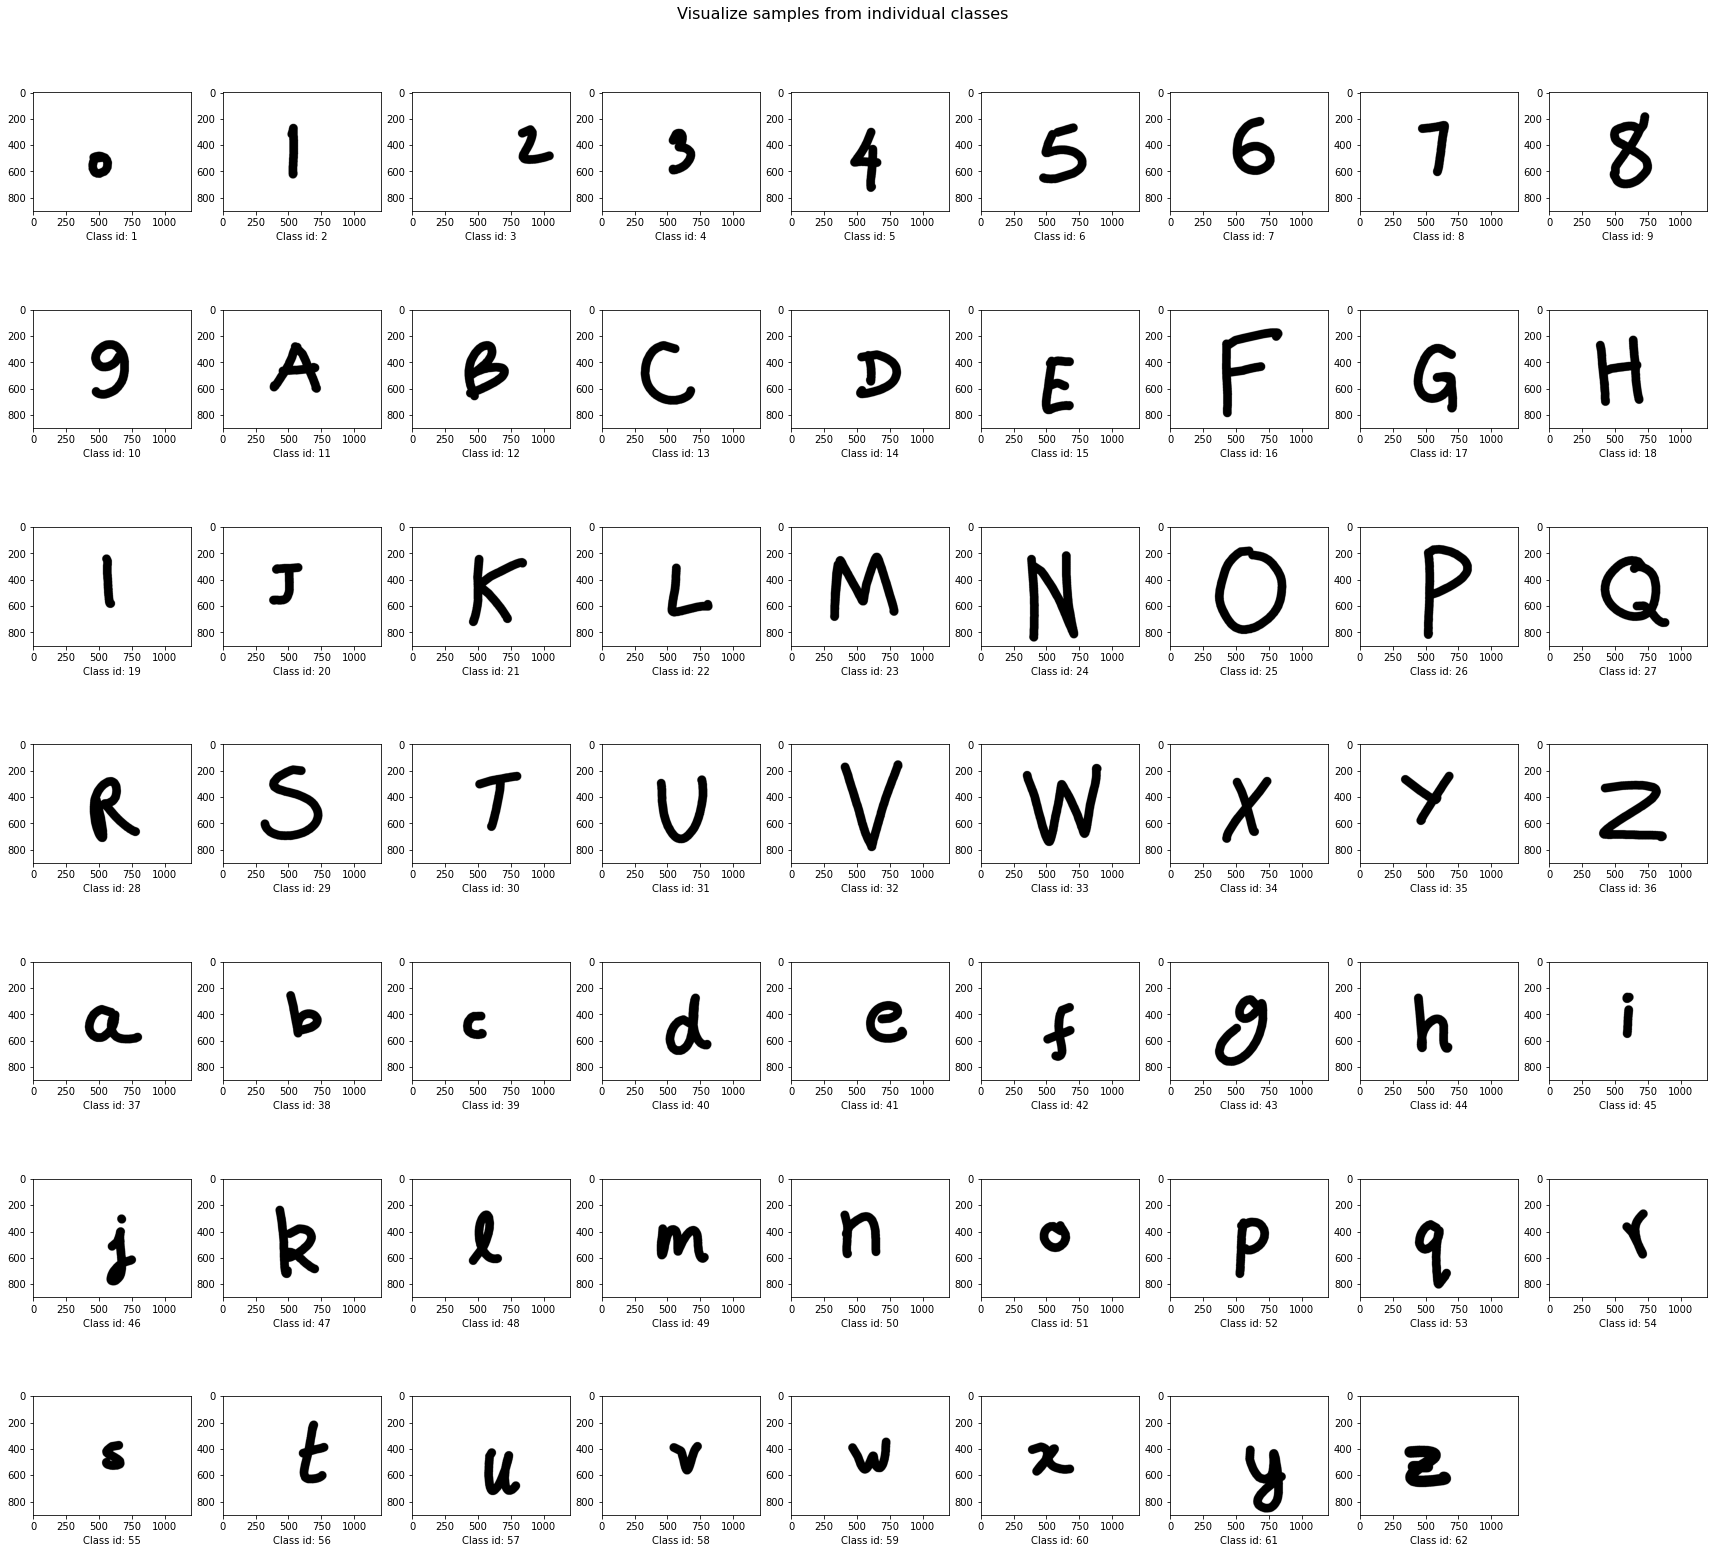

In [41]:
# calling the function to visualize individual random samples
vis_images(img_dir, class_ids)

## Data Loading

**Defining function for creating image array
 and labels list from the folder**

In [42]:
def convert_img_to_array(image_path):
  try:
    img = plt.imread(image_path)
    if img is not None:
      return img_to_array(img)
    else:
      return np.array([])
  
  except Exception as e:
    print(f'Error {e}')
    return None

**Defining function for creating image array and labels list from the folder**

In [43]:
def fetch_img(img_dir):
  samples_list = sorted(os.listdir(img_dir))
  classifiers_path = [os.path.join(img_dir, path) for path in sorted(os.listdir(img_dir))]
  print(f'Classifiers directory names {classifiers_path}')
  # image array list
  image_list = []
  # image labels list
  label_list = []
  # label dataframe
  label_df = pd.DataFrame(columns = sorted(os.listdir(img_dir)))
  # image dataframe
  img_df = pd.DataFrame(columns = ['Image', 'Shape', 'Label'])
  try:
    print('\n[INFO] Acquiring Image Informations ...')
    # total sample count
    sample_count = 0
    for sr, c_path in enumerate(classifiers_path):
      #print(f'[INFO] Processing {samples_list[sr]}')
      path_list = os.listdir(c_path)
      # removing .DS_store files from list if present
      for cs in path_list:
        if cs == '.DS_store':
          path_list.remove(cs)
      
      # categorical count
      count = 0
      for class_sample in path_list:
        class_sample_path = os.path.join(c_path, class_sample)
        if class_sample_path.endswith(".jpg")==True or class_sample_path.endswith(".JPG")==True or class_sample_path.endswith(".png")==True:
          img = convert_img_to_array(class_sample_path)
          #image_list.append(img)
          #label_list.append(class_ids[sr])
          img_df.loc[sample_count, 'Image'], img_df.loc[sample_count, 'Label'] = class_sample, class_ids[sr]
          img_df.loc[sample_count, 'Shape'] = img.shape
          count += 1
          sample_count += 1

      label_df.loc[0, samples_list[sr]] = count
    print('Done!')
    return label_df, img_df
    #image_list, label_list, 

  except Exception as e:
    print(f'Error {e}')
    return None 

In [44]:
# load dataframes for inspection
ldf, img_df = fetch_img(img_dir)

Classifiers directory names ['/content/master_data/train/Sample001', '/content/master_data/train/Sample002', '/content/master_data/train/Sample003', '/content/master_data/train/Sample004', '/content/master_data/train/Sample005', '/content/master_data/train/Sample006', '/content/master_data/train/Sample007', '/content/master_data/train/Sample008', '/content/master_data/train/Sample009', '/content/master_data/train/Sample010', '/content/master_data/train/Sample011', '/content/master_data/train/Sample012', '/content/master_data/train/Sample013', '/content/master_data/train/Sample014', '/content/master_data/train/Sample015', '/content/master_data/train/Sample016', '/content/master_data/train/Sample017', '/content/master_data/train/Sample018', '/content/master_data/train/Sample019', '/content/master_data/train/Sample020', '/content/master_data/train/Sample021', '/content/master_data/train/Sample022', '/content/master_data/train/Sample023', '/content/master_data/train/Sample024', '/content/m

## Target Distribution in the Dataset

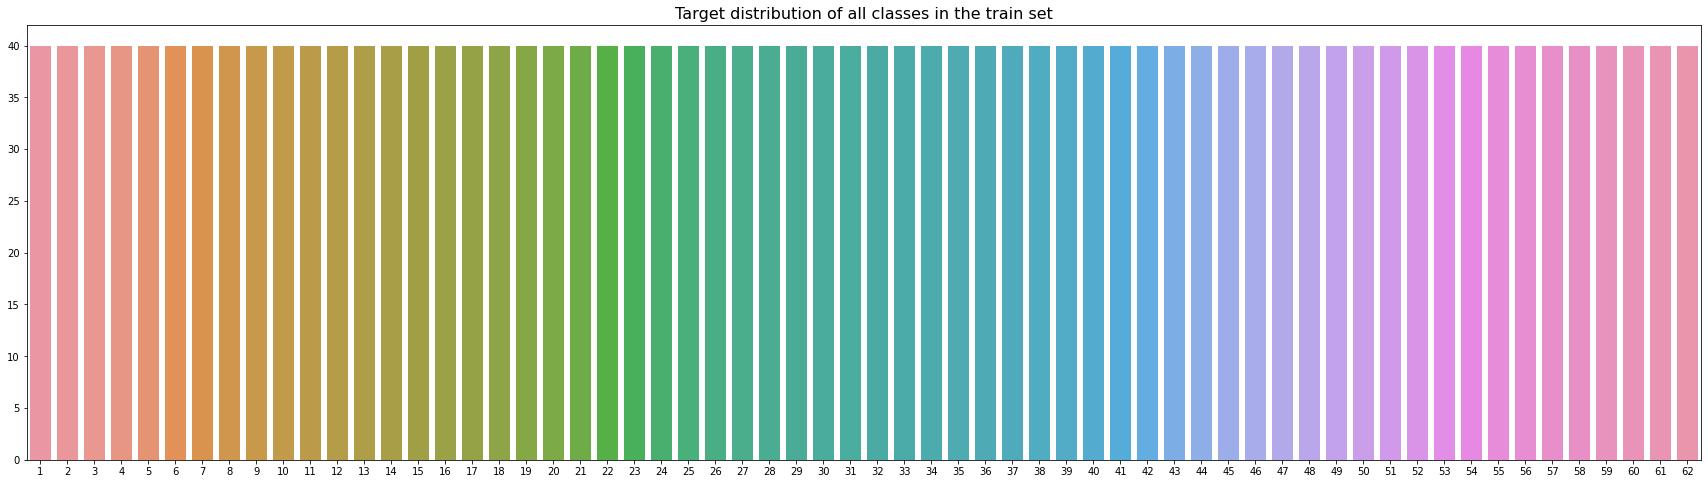

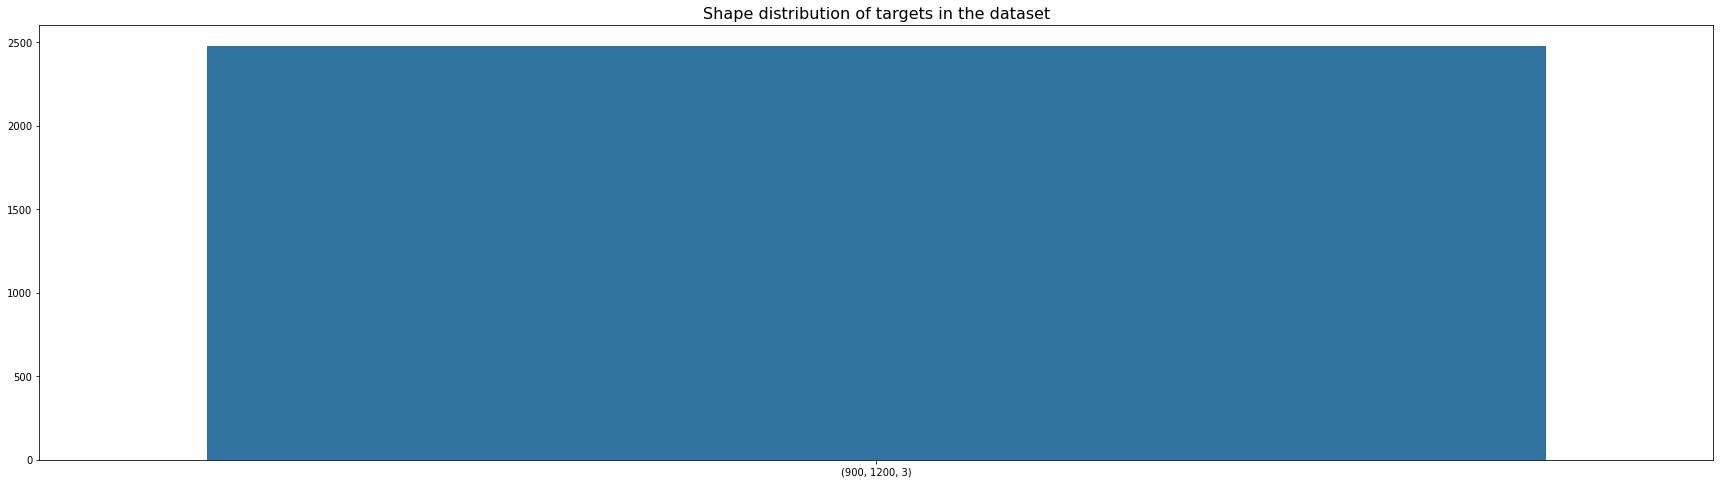

In [45]:
def distribution_vis(counts_series_train, label):
  '''
  Target data distribution in the train data
  '''
  fig = plt.figure(figsize=(30,8))
  sns.barplot(x = counts_series_train.index, y = counts_series_train.values)
  plt.title(label, fontsize = 16)

# returns pandas series with classes as keys and count as values fo train set
target_counts_train = img_df['Label'].value_counts()

# shape analysis for train set
shape_counts_train = img_df['Shape'].value_counts()

# visualize target distribution
distribution_vis(target_counts_train, label = 'Target distribution of all classes in the train set')

# visualize the shape distribution
distribution_vis(shape_counts_train, label = 'Shape distribution of targets in the dataset')

**Conclusion:**

* From the above analysis, the distribution of all the classes in the datasets are equal, i.e 40 samples for each class.
* Also, the shapes of all the samples across the dataset are equal to (900,1200,3)


# Data Pre-processing

Discussion:

Based on the target data to be tested that is the MNIST data, following pre-processing steps are used
1. Rescaing
2. Resizing(Interpolation technique check needed) to target size (28,28)
3. Changing color mode to reduce number of channels.
4. Creating Batches

## Interpolation check

Here we will compare between two of the popular interpolation methods with target size (28,28)

**1. Bilinear spline**, 
**2. Bicubic spline**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0, 'After Bicubic Interpolation')

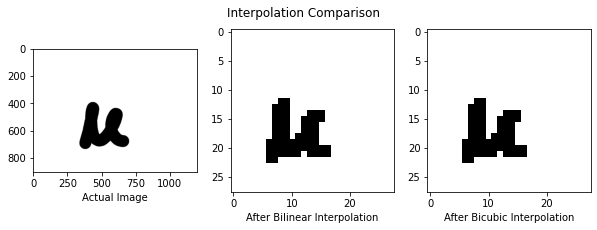

In [46]:
# obtain a random category from the dataset
img_cat = random.choice(os.listdir(img_dir))
# folder path
cat_path = os.path.join(img_dir,img_cat)

# obtain random sample corresponding to the category
img_name = random.choice(os.listdir(cat_path))
# image path
img_path = os.path.join(cat_path, img_name)
# obtain the image
img = plt.imread(img_path)

# bilinear spline interpolation 
img_linear = tf.keras.preprocessing.image.smart_resize(img, size = (28,28),
                                                       interpolation='bilinear')

# bicubic spline interpolation 
img_cubic = tf.keras.preprocessing.image.smart_resize(img, size = (28,28),
                                                       interpolation='bicubic')


fig = plt.figure(figsize = (10,3))
fig.suptitle('Interpolation Comparison')

# before interpolation
fig.add_subplot(131)
plt.imshow(img)
plt.xlabel('Actual Image')

# after bilinear
fig.add_subplot(132)
plt.imshow(img_linear)
plt.xlabel('After Bilinear Interpolation')

# after bicubic
fig.add_subplot(133)
plt.imshow(img_cubic)
plt.xlabel('After Bicubic Interpolation')


**Conclusion:** On going through several samples we can find Bicubic Interpolation is the suitable here.

## Image pre-peocessing and data preperation using keras ImageDataGenerator

**Steps**

1. Test 1

* Only rescaling is used to normalize the image in 1st pre-processing step. Later based on model performance further techniques can be added.
* For the flow from directory batch size = 32, shuffle = True, class_mode = Sparse, seed = 1 used.[link text](https://)

[Reference](https://keras.io/api/preprocessing/image/)

In [47]:
# define batch size based on which train datagen will prepare the data
batch_size = 32

In [48]:
# creating imagedatagenerator object using keras
train_datagen = ImageDataGenerator(rotation_range=None,
                                   width_shift_range = None,
                                   height_shift_range = None,
                                   brightness_range = None,
                                   zoom_range = 0.0,
                                   rescale = 1./255.,
                                   preprocessing_function = None,
                                   dtype = np.float32,
                                   validation_split = 0.1 #using validation split on same train data for validation
                                   )

# provide same seed and keyword arguments to the fit and flow methods 
seed = 1

# obtaining images from tarin directory and apply augmentation using train datagen to create batches
train_generator = train_datagen.flow_from_directory(directory=img_dir,
                                                    target_size = (28,28),
                                                    color_mode = "grayscale", # images are converted to grayscale
                                                    classes = None,
                                                    class_mode = "sparse", # sparse categorical helps to reduce space
                                                    batch_size = batch_size,
                                                    shuffle = True,
                                                    seed = seed,
                                                    subset = 'training'
)

# use same train_datagen for creating the validation set
validation_generator = train_datagen.flow_from_directory(directory = img_dir,
                                                    target_size = (28,28),
                                                    color_mode = "grayscale", # images are converted to grayscale
                                                    classes = None,
                                                    class_mode = "sparse", # sparse categorical helps to reduce space
                                                    batch_size = batch_size,
                                                    shuffle = True,
                                                    seed = seed,
                                                    subset = 'validation'
)     

Found 2232 images belonging to 62 classes.
Found 248 images belonging to 62 classes.


## Sample images after preprocessing

Defining the visualization function to visualize individual sample of each class

In [49]:
def img_label_samples(train_generator, class_count = 62):
  '''
  Fetches 1st sample of each class from 0 to 61
  Along with the class label or id
  Takes total class samples to be visualized 
  Batch count as attributes
  '''
  # total batches in the train datagenerator
  batch_count = len(train_generator)
  # image list initialization
  img_list = []
  # labels list
  labels = []

  for cls in range(class_count):
    for batch in range(batch_count):
      # traversing through image label or class id
      # O-> Batch, 1-> Class(for 1, 0 for image), 2-> Index of each image in the batch(0 to 31)
      for i, j in enumerate(train_generator[batch][1][:]):
        if int(j)==cls:
          img_list.append(train_generator[batch][0][i])
          labels.append(int(j))
          break
      if int(j) == cls:
        break
  return img_list, labels 

# obtain image and label list from train_generator
img_list, labels = img_label_samples(train_generator)

Defining function for sample visualization

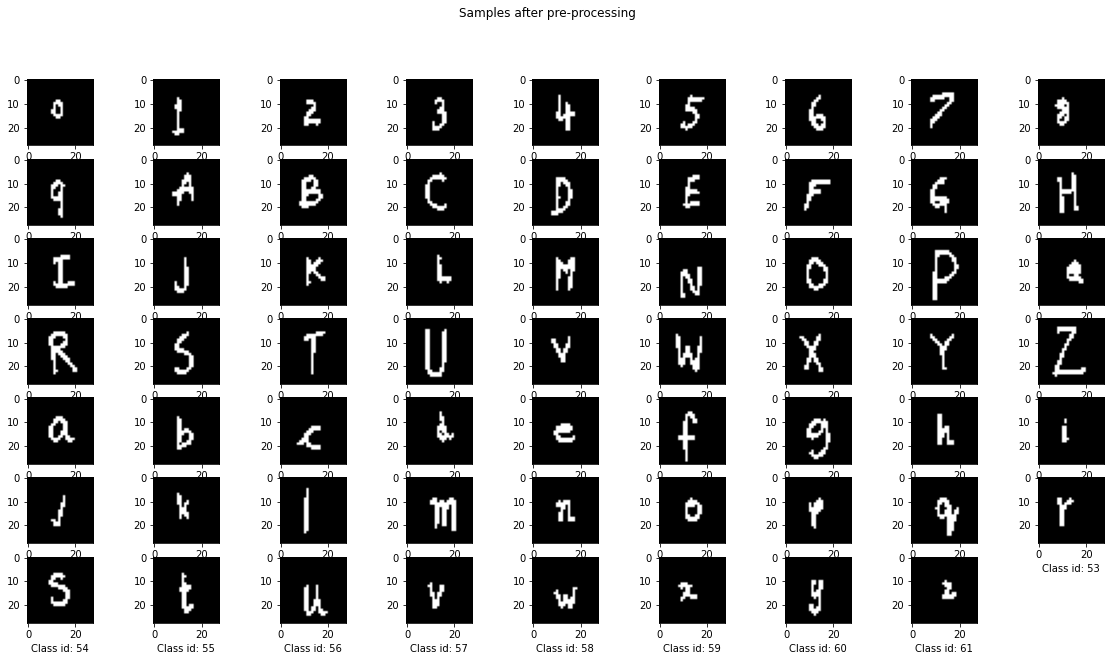

In [50]:
def vis_gen(img_list, labels):
  '''
  62 samples will be visualized
  '''
  cols = 9
  rows = np.ceil(len(img_list)/9)
  fig = plt.figure(figsize=(20,10))
  fig.suptitle('Samples after pre-processing')
  fig.tight_layout()
  for i, c in enumerate(img_list):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(np.squeeze(c), cmap = 'binary')
    plt.xlabel(f'Class id: {labels[i]}')

  plt.show()

# calling the visualization fn
vis_gen(img_list, labels)


## Checking before training and train, validation set configuration inspection

In [51]:
print(f'Train set total batches {len(train_generator)}')
print(f'Validation set total batches {len(validation_generator)}')
print(f'Train set target size {train_generator.target_size}')
print(f'Validation set target size {validation_generator.target_size}')


# assertion checks
assert train_generator.dtype == validation_generator.dtype == 'float32' 
assert train_generator.batch_size == validation_generator.batch_size == batch_size
assert train_generator.class_mode == validation_generator.class_mode
assert train_generator.target_size == validation_generator.target_size

print('All checks are successful')

Train set total batches 70
Validation set total batches 8
Train set target size (28, 28)
Validation set target size (28, 28)
All checks are successful


# **Model Building**

Test steps
1. In the 1st test a simple custom model archutecture is used using keras functional API

In [52]:
# input image shape = (28,28,1)
input_shape = train_generator.image_shape
# num_classes = 62
num_classes = train_generator.num_classes
print(f'Model input_shape {input_shape}')
print(f'Number of output class {num_classes}')

Model input_shape (28, 28, 1)
Number of output class 62


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               204928

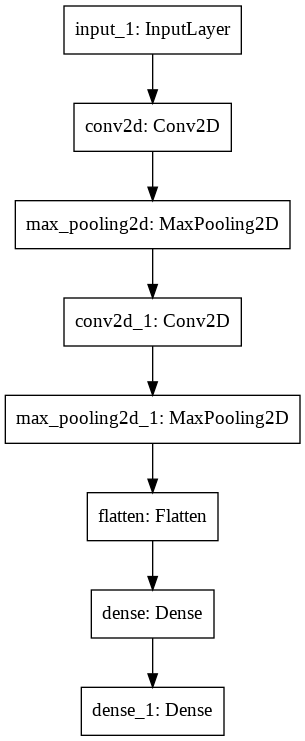

In [53]:
def model(input_shape, num_classes):
  '''
  Defining the model with keras fuctional API
  '''
  inputs = keras.layers.Input(shape = input_shape)

  x = keras.layers.Conv2D(filters = 32, kernel_size= 3, activation = 'relu', strides = 1)(inputs)
  #x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPooling2D(pool_size=2, strides = 2)(x)
  x = keras.layers.Conv2D(filters = 64, kernel_size= 3, activation = 'relu', strides = 1)(x)
  #x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPooling2D(pool_size=2, strides = 2)(x)
  #x = keras.layers.Conv2D(filters = 64, kernel_size= 3, activation = 'relu', strides = 1)(x)
  #x = keras.layers.BatchNormalization()(x)
  #x = keras.layers.MaxPooling2D(pool_size=2, strides = 2)(x)
  #x = keras.layers.Conv2D(filters = 32, kernel_size= 3, activation = 'relu', strides = 1)(x)
  #x = keras.layers.BatchNormalization()(x)
  #x = keras.layers.MaxPooling2D(pool_size=2, strides = 2)(x)
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(128, activation='relu')(x)
  #x = keras.layers.Dropout(rate=0.3)(x)
  output = keras.layers.Dense(num_classes, activation='softmax')(x)
  
  return keras.models.Model(inputs = inputs, outputs = output)

model = model(input_shape, num_classes)
model.summary()
# save the model structure as image
plot_model(model)

# Model Training

#### Defining Hyperparameters and metadata



In [54]:
# initial/ optimal LR
learning_rate = 0.001 # tobe tuned using scheduler
epochs = 20
loss_fn = 'sparse_categorical_crossentropy'

#### Configuring wandb to initialize and log training

Weights and Biases will help to track the training log, checkpoints and create custom project report, here we will use it to record and create training history and reports respectively.

[Reference](https://github.com/wandb/client)

In [55]:
'''
Instruction: Initialize everytime before using wandbcallback and run.join()
'''
# initialize wandb with the project

run = wandb.init(project = 'Master Training',
                 config = {
                     "learning_rate": learning_rate,
                     "epochs": epochs,
                     "batch_size": train_generator.batch_size,
                     "loss_function": loss_fn,
                     "architecture": "CNN",
                     "dataset": 'Trainset'
                 })

# will be used to configure the experiment log for wandb tracking 
config = wandb.config

# defining the optimizer
optimizer = Adam(config.learning_rate)

# model compile
model.compile(optimizer = optimizer, loss = loss_fn, metrics = ['acc'])

epoch,19
loss,1.44518
acc,0.64337
val_loss,1.91284
val_acc,0.52823
_runtime,703
_timestamp,1617983879
_step,19
best_val_loss,1.91284
best_epoch,19


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▇▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
acc,▁▂▄▅▆▆▇▇▇▇▇▇▇███████
val_loss,█▆▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▅▅▆▆▇▇▇▇█▇████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


**Storing initial weights of the model for resetting weights**

In [56]:
# use only once after 1st compiling
model.save_weights('model_initial.h5')

#### Defining model callbacks

Callbacks
1. Modelcheckpoint: Model checkpoints will be saved(only weights) after each epoch with the dynamic name of epoch number, validation accuracy
2. Learning rate scheduler is used to make the training curve smooth for better optimality or to choose an optimal learning rate for training
3. Reduce Learnin Rate on Plateu is used to rescue the training curve when it is stuck in a plateu over a sepcified episodes


In [57]:
# model checkpoint
filepath = 'Master_training_epoch_{epoch:02d}.hdf5'
#-acc_{accuracy:0.4d}.hdf5'
# defining model checkpoint object
mc = ModelCheckpoint(filepath = filepath, monitor = 'acc', save_weights_only= True, mode = 'max', verbose = 1)

# reduce Learning rate on Plateu
# if it observes training curve(val_acc) is stuck in plateu, reduces LR by factor 0.2 with patience = 5
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'acc',
                                                 factor = 0.2,
                                                 patience = 5
                                                 )
# schedule Learning rate
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-03/(epoch+1)
)

**Clear the session and reset model weights whenever need to retrain from scratch and restart the session**


In [58]:
# clearing session
keras.backend.clear_session()

Reset weights

In [59]:
# used it when it needed to initialize to train from scratch
model.load_weights('model_initial.h5')
# check initialize with train data
model.evaluate(train_generator)

70/70 [==============================] - 29s 416ms/step - loss: 4.1344 - acc: 0.0158


[4.132621765136719, 0.016577061265707016]

## Model Training

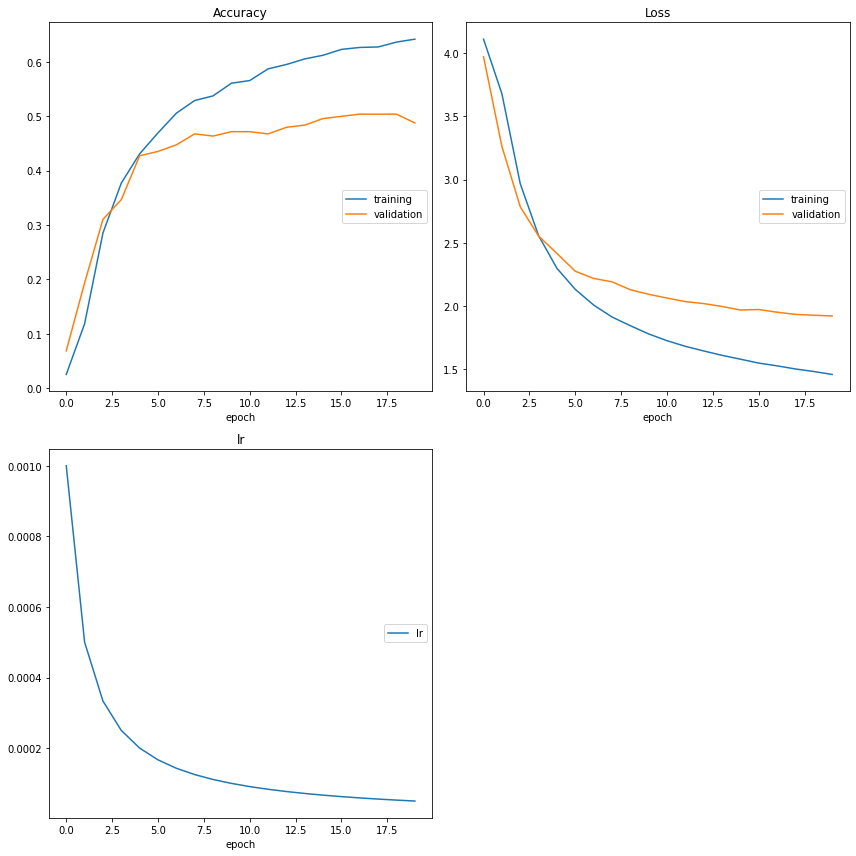

Accuracy
	training         	 (min:    0.025, max:    0.642, cur:    0.642)
	validation       	 (min:    0.069, max:    0.504, cur:    0.488)
Loss
	training         	 (min:    1.461, max:    4.108, cur:    1.461)
	validation       	 (min:    1.923, max:    3.969, cur:    1.923)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)


In [60]:
history = model.fit(train_generator, epochs = epochs, verbose = 1, validation_data= validation_generator,
                              callbacks = [WandbCallback(), mc, lr_schedule, reduce_lr, PlotLossesKeras()])

                    #, use_multiprocessing = True)

##  Training evaluation and pick a suitable weights file

In [61]:
# based on final validation accuracy we are picking the model
val_loss, val_acc = model.evaluate(validation_generator)

# wandb log analysis
wandb.log({'Validation error': round((1 - val_acc) * 100, 2)})

run.join()

8/8 [==============================] - 3s 377ms/step - loss: 1.9227 - acc: 0.4879


epoch,19
loss,1.46087
acc,0.64203
val_loss,1.92269
val_acc,0.4879
_runtime,661
_timestamp,1617985360
_step,20
best_val_loss,1.92269
best_epoch,19
Validation error,51.21


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▇▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
acc,▁▂▄▅▆▆▆▇▇▇▇▇▇███████
val_loss,█▆▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▅▅▇▇▇▇▇▇▇▇████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇███
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Validation error,▁


#### WandB log analysis and Save model

Test 1: According to wandb analysis best epoch is epoch (19+1)

In [62]:
best_weights_file = '/content/Master_training_epoch_20.hdf5'
random_initialized_weights_file = '/content/model_initial.h5'

# saving model architecture as json
model_json = model.to_json()
with open("model_final.json", "w") as json_file:
  json_file.write(model_json)

model_json_file = '/content/model_final.json'

print(f'Best weight file for the model {best_weights_file}')
print(f'Best weight file for the model {random_initialized_weights_file}')
print(f'Model json file {model_json_file}')

Best weight file for the model /content/Master_training_epoch_20.hdf5
Best weight file for the model /content/model_initial.h5
Model json file /content/model_final.json


In [63]:
# final evaluation check
model.load_weights(best_weights_file)
model.evaluate(validation_generator)

8/8 [==============================] - 3s 377ms/step - loss: 1.9227 - acc: 0.4879


[1.9226917028427124, 0.4879032373428345]

## WandB detailed Training Reports
Main project page: Visit this [link](
https://wandb.ai/sayan0506/Master%20Training?workspace=user-sayan0506) to find all the training records till now for that project 

Test 1 report:
https://wandb.ai/sayan0506/Master%20Training/reports/Project-Dashboard--Vmlldzo1OTI5Nzg

Test 2 report: https://wandb.ai/sayan0506/Master%20Training/reports/Project-Dashboard--Vmlldzo1OTM0MDA

* Project page in wandb: https://wandb.ai/sayan0506/Master%20Training?workspace=user-sayan0506, https://wandb.ai/sayan0506/Master%20Training/runs/3uf8vn29?workspace=user-sayan0506

# **Section 2**

# Load Standard MNIST Dataset using Keras

[Reference](https://keras.io/api/datasets/mnist/#load_data-function)

In [64]:
# load mnist by using standard train_test split
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data(path = "mnist.npz")

11493376/11490434 [==============================] - 0s 0us/step


# **Data Inspection on MNIST**

In [65]:
print(f'Train input shape {x_train.shape}')
print(f'Train label shape {y_train.shape}')
print(f'Test input shape {x_test.shape}')
print(f'Test label shape {y_test.shape}')

Train input shape (60000, 28, 28)
Train label shape (60000,)
Test input shape (10000, 28, 28)
Test label shape (10000,)


## Analyzing train and test distribution

In [66]:
# dataframe for train distribution
train_df = pd.DataFrame(y_train, columns = ['Targets'])

# dataframe for test distribution
test_df = pd.DataFrame(y_test, columns = ['Targets'])

# train and test value counts
train_c = train_df.value_counts()
test_c = test_df.value_counts()

In [67]:
# class ids
class_ids = [i for i in range(10)]
print(f"Class ids {class_ids}")

Class ids [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


**Visualize the distribution for train and test set**

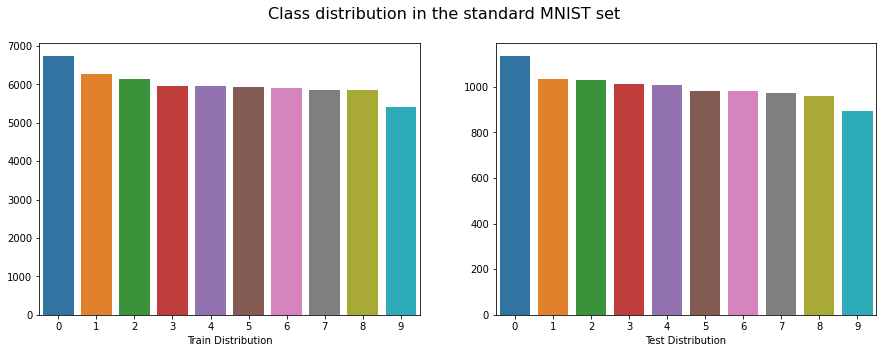

In [68]:
fig = plt.figure(figsize = (15,5))
fig. suptitle('Class distribution in the standard MNIST set', fontsize=16)
fig.tight_layout()

# train distribution
fig.add_subplot(121)
sns.barplot(x = class_ids, y = train_c.values)
plt.xlabel('Train Distribution')

# test distribution
fig.add_subplot(122)
sns.barplot(x = class_ids, y = test_c.values)
plt.xlabel('Test Distribution')

plt.show()

We can see both train and test data are stratified split. 

## Sample Visualization of MNIST samples for individual Classes

Picking random sample of each class from train set and visualize

In [69]:
def mnist_vis(x_train, y_train, class_ids):
  '''
  Visualize random MNIST samples
  '''
  index_list = [random.choice([j for j,label in enumerate(y_train) if label==i])
   for i in class_ids]
  
  # obtaining sample images from train set
  sample_img = [x_train[index] for index in index_list]
  
  rows = 2
  cols = int(len(index_list)/rows)

  fig = plt.figure(figsize = (15,5))
  fig.suptitle('MNISt samples visualization', fontsize = 16)
  fig.tight_layout()
  
  for a,idx in enumerate(index_list):
    fig.add_subplot(rows, cols, a+1)
    plt.imshow(x_train[idx], cmap = 'gray')
    plt.xlabel(f'Label: {a}')

  plt.show()


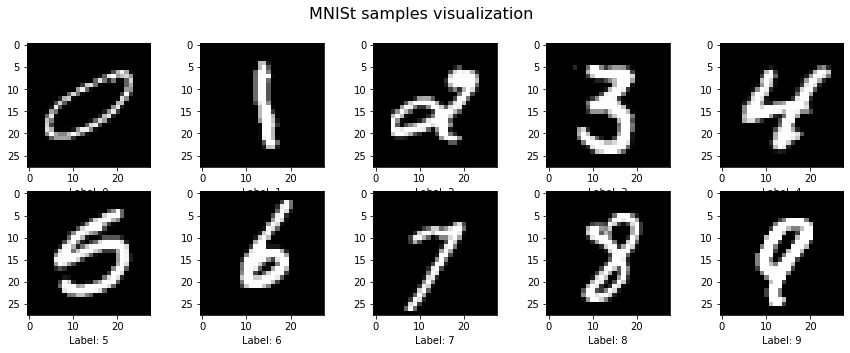

In [70]:
# calling visualization
mnist_vis(x_train, y_train, class_ids)

# **Data Preperation MNIST**

Data preprocessing steps include

1. Converting image pixels to float32
2. Normalizing the pixels
3. Reshaping

In [71]:
def mnist_prep(x_train, x_test):
  # convert images pixel to standrad float32
  x_train_norm = x_train.astype(np.float32)
  x_test_norm = x_test.astype(np.float32)

  # normalize the pixels
  x_train_norm = x_train_norm/255.0
  x_test_norm = x_test_norm/255.0

  # reshape the data
  x_train = x_train_norm.reshape(x_train.shape[0], 28, 28, 1)
  x_test = x_test_norm.reshape(x_test.shape[0], 28, 28, 1)

  return x_train, x_test

In [72]:
x_train_pro, x_test_pro = mnist_prep(x_train, x_test)

print(f'Preprocessed train input shape {x_train_pro.shape}')
print(f'Preprocessed test input shape {x_test_pro.shape}')

Preprocessed train input shape (60000, 28, 28, 1)
Preprocessed test input shape (10000, 28, 28, 1)


## Checking the pre-processing steps

In [73]:
# both the input image format are same or not
assert x_train_pro.shape[1:] == x_test_pro.shape[1:] 
# checking length of input and label
assert x_train_pro.shape[0] == y_train.shape[0] and x_test_pro.shape[0] == y_test.shape[0] 
# checking image data type
assert x_train_pro.dtype == x_test_pro.dtype

print("All assertion test case passed")

All assertion test case passed


# Data Loading and Pre-processing for Master Data from 0 to 9

Here we are following same pre-processing techniques as section 1

In [74]:
# list of samples from main dataset at section 1
samples_list = sorted(os.listdir(img_dir))

# obtaining path of sample from class id 0 to 9
classifiers_path_2 = [os.path.join(img_dir, path) for path in sorted(os.listdir(img_dir))[:10]]
# list of classes to be passed in train and validation generator for this section
class_list_2 = sorted(os.listdir(img_dir))[:10]
print(f'Folder list {class_list_2}')
print('\nClassifiers path')
for path in classifiers_path_2:  print(path)

Folder list ['Sample001', 'Sample002', 'Sample003', 'Sample004', 'Sample005', 'Sample006', 'Sample007', 'Sample008', 'Sample009', 'Sample010']

Classifiers path
/content/master_data/train/Sample001
/content/master_data/train/Sample002
/content/master_data/train/Sample003
/content/master_data/train/Sample004
/content/master_data/train/Sample005
/content/master_data/train/Sample006
/content/master_data/train/Sample007
/content/master_data/train/Sample008
/content/master_data/train/Sample009
/content/master_data/train/Sample010


**Defining train and validation generator using Keras ImageDataGenerator**

Note: Using same configuration as used in section 1

In [75]:
# using batch size as 32 
batch_size = 32

In [76]:
# creating imagedatagenerator object using keras
train_datagen_2 = ImageDataGenerator(rotation_range=None,
                                   width_shift_range = None,
                                   height_shift_range = None,
                                   brightness_range = None,
                                   zoom_range = 0.0,
                                   rescale = 1./255.,
                                   preprocessing_function = None,
                                   dtype = np.float32,
                                   validation_split = 0.1 #using validation split on same train data for validation
                                   )

# provide same seed and keyword arguments to the fit and flow methods 
seed = 1

# obtaining images from tarin directory and apply augmentation using train datagen to create batches
train_generator_2 = train_datagen.flow_from_directory(directory=img_dir,
                                                    target_size = (28,28),
                                                    color_mode = "grayscale", # images are converted to grayscale
                                                    classes = class_list_2,
                                                    class_mode = "sparse", # sparse categorical helps to reduce space
                                                    batch_size = batch_size,
                                                    shuffle = True,
                                                    seed = seed,
                                                    subset = 'training'
)

# use same train_datagen for creating the validation set
validation_generator_2 = train_datagen.flow_from_directory(directory = img_dir,
                                                    target_size = (28,28),
                                                    color_mode = "grayscale", # images are converted to grayscale
                                                    classes = class_list_2,
                                                    class_mode = "sparse", # sparse categorical helps to reduce space
                                                    batch_size = batch_size,
                                                    shuffle = True,
                                                    seed = seed,
                                                    subset = 'validation'
)     

Found 360 images belonging to 10 classes.
Found 40 images belonging to 10 classes.


**Checking before training and train, validation set configuration inspection**

In [77]:
print(f'Train set total batches {len(train_generator_2)}')
print(f'Validation set total batches {len(validation_generator_2)}')
print(f'Train set target size {train_generator_2.target_size}')
print(f'Validation set target size {validation_generator_2.target_size}')


# assertion checks
assert train_generator_2.dtype == validation_generator_2.dtype == 'float32' 
assert train_generator_2.batch_size == validation_generator_2.batch_size == batch_size
assert train_generator_2.class_mode == validation_generator_2.class_mode
assert train_generator_2.target_size == validation_generator_2.target_size

print('All checks are successful')

Train set total batches 12
Validation set total batches 2
Train set target size (28, 28)
Validation set target size (28, 28)
All checks are successful


# **Model Preperation**

## Load the model from json

[Reference](https://machinelearningmastery.com/save-load-keras-deep-learning-models/)

In [81]:
# open json file in read mode
json_file = open(model_json_file, 'r')
# read the file
loaded_model_json = json_file.read()
# close the file
json_file.close()

# load the model
loaded_model = model_from_json(loaded_model_json)

# summary check
loaded_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               204928

## Rebuild the Model

Loading the same model, but instead of the last layer which had 62 perceptrons for 62 classes, this model omits that layer and instead adding a new layer having 10 nodes for the 10 output classes having softmax activation.

In [82]:
# input to the last layer or output to the 2nd last layer
mnist_x = loaded_model.layers[-1].input
# adding final Dense layer having 10 nodes
mnist_x = tf.keras.layers.Dense(10, activation='softmax')(mnist_x)

# defining the model using keras functional API
model_mnist = tf.keras.models.Model(inputs=loaded_model.input, outputs = mnist_x)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               2049

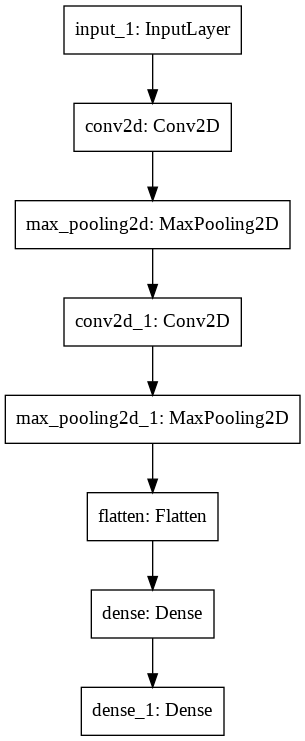

In [83]:
# checking model summary and visualize
model_mnist.summary()
# plot model
plot_model(model_mnist)

# **Model Training Section 2**

#### Defining Hyperparameters and metadata



In [84]:
# initial/ optimal LR
learning_rate = 0.001 # tobe tuned using scheduler
epochs = 20
loss_fn = 'sparse_categorical_crossentropy'

#### Configuring wandb to initialize and log training

Weights and Biases will help to track the training log, checkpoints and create custom project report, here we will use it to record and create training history and reports respectively.

[Reference](https://github.com/wandb/client)

In [132]:
'''
Instruction: Initialize everytime before using wandbcallback and run.join()
'''
# initialize wandb with the project

run = wandb.init(project = 'MNIST Training section 2',
                 config = {
                     "learning_rate": learning_rate,
                     "epochs": epochs,
                     "batch_size": train_generator.batch_size,
                     "loss_function": loss_fn,
                     "architecture": "CNN",
                     "dataset": 'Trainset'
                 })

# will be used to configure the experiment log for wandb tracking 
config = wandb.config

# defining the optimizer
optimizer = Adam(config.learning_rate)

# model compile
model_mnist.compile(optimizer = optimizer, loss = loss_fn, metrics = ['acc'])

**Storing initial weights of the MNIST model for resetting weights**

In [86]:
# use only once after 1st compiling
model_mnist.save_weights('mnist_model_initial.h5')

#### Defining model callbacks(Same as section 1)

Callbacks
1. Modelcheckpoint: Model checkpoints will be saved(only weights) after each epoch with the dynamic name of epoch number, validation accuracy
2. Learning rate scheduler is used to make the training curve smooth for better optimality or to choose an optimal learning rate for training
3. Reduce Learnin Rate on Plateu is used to rescue the training curve when it is stuck in a plateu over a sepcified episodes

In [91]:
# model checkpoint
filepath_mnist = 'MNIST_training_epoch_{epoch:02d}.hdf5'
#-acc_{accuracy:0.4d}.hdf5'
# defining model checkpoint object
mc_mnist = ModelCheckpoint(filepath = filepath_mnist, monitor = 'val_acc', save_weights_only= True, mode = 'max', verbose = 1)

# reduce Learning rate on Plateu
# if it observes training curve(val_acc) is stuck in plateu, reduces LR by factor 0.2 with patience = 5
reduce_lr_mnist = keras.callbacks.ReduceLROnPlateau(monitor = 'val_acc',
                                                 factor = 0.2,
                                                 patience = 5
                                                 )
# schedule Learning rate
lr_schedule_mnist = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-03/(epoch+1)
)

**Clear the session and reset model weights whenever need to retrain from scratch and restart the session**


In [92]:
# clearing session
keras.backend.clear_session() 

# used it when it needed to initialize to train from scratch
model_mnist.load_weights('mnist_model_initial.h5')
# check initialize with train data
model_mnist.evaluate(train_generator_2)
# check initialize with train data
model_mnist.evaluate(x_train_pro, y_train)

1875/1875 [==============================] - 5s 2ms/step - loss: 2.3029 - acc: 0.0498


[2.3028576374053955, 0.0497666671872139]

## **Training the standard pre-processed MNIST Dataset with Random initialization**

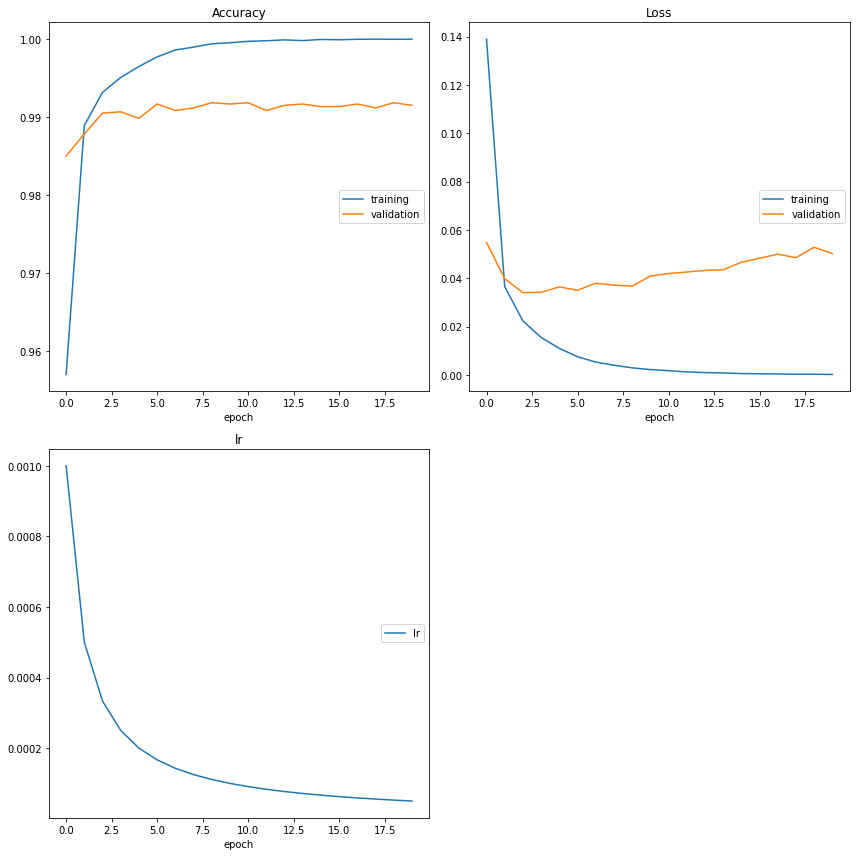

Accuracy
	training         	 (min:    0.957, max:    1.000, cur:    1.000)
	validation       	 (min:    0.985, max:    0.992, cur:    0.992)
Loss
	training         	 (min:    0.000, max:    0.139, cur:    0.000)
	validation       	 (min:    0.034, max:    0.055, cur:    0.050)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)


In [95]:
# random initialized training
history_mnist_rinit = model_mnist.fit(x = x_train_pro, y = y_train, epochs = epochs, verbose = 1, validation_split = 0.1, 
                                      callbacks = [WandbCallback(), mc_mnist, lr_schedule_mnist, reduce_lr_mnist, PlotLossesKeras()])

                    #, use_multiprocessing = True)

####  Training evaluation and pick a suitable weights file for MNIST with randomized initializtion training

In [96]:
# based on final validation accuracy we are picking the model
val_loss, val_acc = model.evaluate(x_test_pro, y_test)

# wandb log analysis
wandb.log({'Test error': round((1 - val_acc) * 100, 2)})

run.join()

313/313 [==============================] - 1s 3ms/step - loss: 7.1572 - acc: 0.0372


epoch,19
loss,0.00024
acc,0.99998
val_loss,0.05025
val_acc,0.9915
_runtime,137
_timestamp,1617986274
_step,20
best_val_loss,0.03409
best_epoch,2
Test error,96.28


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,▁▆▇▇▇███████████████
val_loss,█▃▁▁▂▁▂▂▂▃▄▄▄▄▅▆▆▆▇▆
val_acc,▁▄▇▇▆█▇▇███▇██▇▇█▇██
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇███
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Test error,▁


#### WandB log analysis

Test 1: According to wandb analysis best epoch is epoch (2+1), after that data overfits

In [97]:
weights_file_randomized = '/content/MNIST_training_epoch_03.hdf5'
model_mnist.load_weights(weights_file_randomized)

# prediction result in this training type
y_pred_randomized = model_mnist.predict(x_test_pro)


model_mnist.evaluate(x_test_pro, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0281 - acc: 0.9914


[0.028093615546822548, 0.9914000034332275]

In [112]:
# transforming multiclass format to single sparse format
y_pred_randomized = np.argmax(y_pred_randomized, 1)

#### WandB detailed Training Reports
Main project page MNIST: Visit this [link](https://wandb.ai/sayan0506/MNIST%20Training%20section%202?workspace=user-sayan0506) to find all the ecords regarding MNIST training

Test 1 report:
https://wandb.ai/sayan0506/MNIST%20Training%20section%202/reports/Project-Dashboard--Vmlldzo1OTM4NzY

**Conclusion: Model gets converged at 3rd epoch or iteration.**

## **Training the master data pre-processed Dataset(0-9) with Random initialization for pretraining before MNIST**

Clear session and initializing the model

In [98]:
# clearing session
keras.backend.clear_session() 

# used it when it needed to initialize to train from scratch
model_mnist.load_weights('mnist_model_initial.h5')
# check initialize with train data
model_mnist.evaluate(train_generator_2)
# check initialize with train data
model_mnist.evaluate(x_train_pro, y_train)

1875/1875 [==============================] - 4s 2ms/step - loss: 2.3029 - acc: 0.0498


[2.3028576374053955, 0.0497666671872139]

**Note:** We initialize the training for multiple times and the result is reproducible, because of the code snippet we used to improved keras reproducibility

In [99]:
epochs_main_2 = 70

# model checkpoint for this section
filepath_mnist_master = 'MNIST_training_masterrnit_epoch_{epoch:02d}.hdf5'
#-acc_{accuracy:0.4d}.hdf5'
# defining model checkpoint object
mc_mnist_master = ModelCheckpoint(filepath = filepath_mnist_master, monitor = 'val_acc', save_weights_only= True, mode = 'max', verbose = 1)


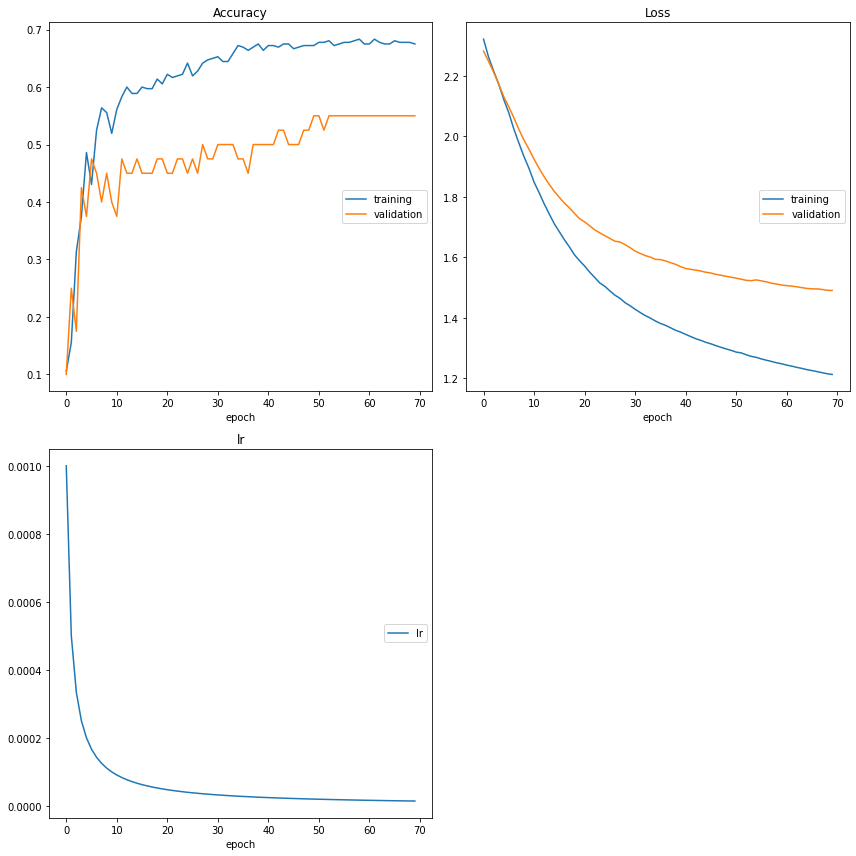

Accuracy
	training         	 (min:    0.106, max:    0.683, cur:    0.675)
	validation       	 (min:    0.100, max:    0.550, cur:    0.550)
Loss
	training         	 (min:    1.213, max:    2.321, cur:    1.213)
	validation       	 (min:    1.491, max:    2.281, cur:    1.491)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)


In [102]:
# random initialized training
history_master_rinit = model_mnist.fit(train_generator_2, epochs = epochs_main_2, verbose = 1, validation_data= validation_generator_2, 
                                      callbacks = [WandbCallback(), mc_mnist_master, lr_schedule_mnist, reduce_lr_mnist, PlotLossesKeras()])


####  Training evaluation and pick a suitable weights file for master data(0-9) with randomized initializtion training

In [ ]:
# based on final validation accuracy we are picking the model
val_loss, val_acc = model_mnist.evaluate(validation_generator_2)

# wandb log analysis
wandb.log({'Test error': round((1 - val_acc) * 100, 2)})

run.join()

2/2 [==============================] - 1s 108ms/step - loss: 1.5357 - acc: 0.5250


epoch,69
loss,1.28605
acc,0.68889
val_loss,1.53572
val_acc,0.525
_runtime,1240
_timestamp,1617946548
_step,70
best_val_loss,1.53572
best_epoch,69
Test error,47.5


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,██▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
acc,▁▂▅▅▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇██▇█████████████████
val_loss,██▇▇▆▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▅▆▆███▇▇▇█▇▇▇▇▇▇▇██▇▇█████████████████
_runtime,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃█
_timestamp,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Test error,▁


#### WandB log analysis

Test 1: According to wandb analysis best epoch is epoch (69+1)
[Report](https://wandb.ai/sayan0506/MNIST%20Training%20section%202/runs/24ny0bk3)  

In [103]:
weights_file_main = '/content/MNIST_training_masterrnit_epoch_70.hdf5'
model_mnist.load_weights(weights_file_main)

model_mnist.evaluate(validation_generator_2)

2/2 [==============================] - 1s 109ms/step - loss: 1.4906 - acc: 0.5500


[1.4906259775161743, 0.550000011920929]

## **Training the standard pre-processed MNIST Dataset with Random initialization**

In this section we will train that pre-trained model(trained just on data at section 1 from 0 to 9 label) on standard MNIST pre-processed dataset. 

In [104]:
# clearing session
keras.backend.clear_session() 

# used it when it needed to initialize to train from scratch
#model_mnist.load_weights('mnist_model_initial.h5')
# check initialize with train data
#model_mnist.evaluate(train_generator_2)
# check initialize with train data begore training with pre-trained
model_mnist.evaluate(x_train_pro, y_train)

1875/1875 [==============================] - 4s 2ms/step - loss: 2.9181 - acc: 0.1128


[2.9181156158447266, 0.11275000125169754]

In [105]:
# considering the same epoch as used in the randomly inititalized training
epochs_pretrained = 20

# model checkpoint for this section
filepath_mnist_pretrained = 'MNIST_training_pretrained_epoch_{epoch:02d}.hdf5'
#-acc_{accuracy:0.4d}.hdf5'
# defining model checkpoint object
mc_mnist_pretrained = ModelCheckpoint(filepath = filepath_mnist_pretrained, monitor = 'val_acc', save_weights_only= True, mode = 'max', verbose = 1)

MNIST model training on pretrained network

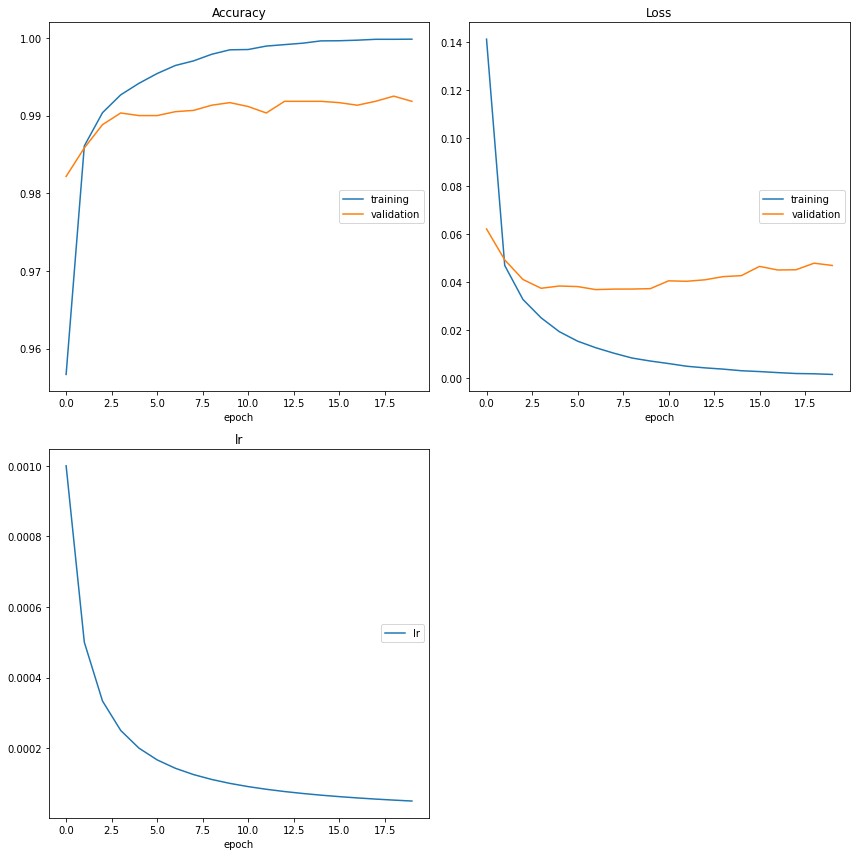

Accuracy
	training         	 (min:    0.957, max:    1.000, cur:    1.000)
	validation       	 (min:    0.982, max:    0.993, cur:    0.992)
Loss
	training         	 (min:    0.002, max:    0.141, cur:    0.002)
	validation       	 (min:    0.037, max:    0.062, cur:    0.047)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)


In [106]:
# random initialized training
history_mnist_pretrained = model_mnist.fit(x = x_train_pro, y = y_train, epochs = epochs_pretrained, verbose = 1, validation_split = 0.1, 
                                      callbacks = [WandbCallback(), mc_mnist_pretrained, lr_schedule_mnist, reduce_lr_mnist, PlotLossesKeras()])

                    #, use_multiprocessing = True)

####  Training evaluation and pick a suitable weights file for MNIST with pretrained CNN training

In [107]:
# based on final validation accuracy we are picking the model
val_loss, val_acc = model_mnist.evaluate(x_test_pro, y_test)

# wandb log analysis
wandb.log({'Test error': round((1 - val_acc) * 100, 2)})

run.join()

313/313 [==============================] - 1s 2ms/step - loss: 0.0323 - acc: 0.9919


epoch,19
loss,0.0015
acc,0.99983
val_loss,0.04691
val_acc,0.99183
_runtime,867
_timestamp,1617987319
_step,90
best_val_loss,0.03685
best_epoch,6
Test error,0.81


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██▁▁▂▂▂▂▂▃▃
loss,██▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▁▁▁▁▁▁▁▁▁
acc,▁▃▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▅▆▅▅▅█████████
val_loss,███▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▁▁▁▁▁▁▁▁▁
val_acc,▁▂▃▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅█████████
_runtime,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▇▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Test error,▁


#### WandB log analysis

Test 1: According to wandb analysis best epoch is epoch (6+1).

In [108]:
weights_file_pretrained = '/content/MNIST_training_pretrained_epoch_07.hdf5'
model_mnist.load_weights(weights_file_pretrained)

# prediction result in this training type
y_pred_pretrained = model_mnist.predict(x_test_pro)

model_mnist.evaluate(x_test_pro, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0262 - acc: 0.9921


[0.026177160441875458, 0.9921000003814697]

In [113]:
# transforming multiclass format to single sparse format
y_pred_pretrained = np.argmax(y_pred_pretrained, 1)

# Model Evaluation and prediction analysis between randomly initialized model and the pre-trained MNIST trained on Section 1 dataset(0-9 label)

## Comparing classification report and overall accuracy score for both the Rnadomly initialized model and pre-trained model

In [117]:
print(f'Classification report for Randomly Initialized MNIST Model\n{metrics.classification_report(y_test, y_pred_randomized)}')
print(f'Overall classification accuracy score for randomly initialized MNIST model {metrics.accuracy_score(y_test, y_pred_randomized)*100: 0.2f}\n')
print(f'Classification report for Pretrained MNIST Model\n{metrics.classification_report(y_test, y_pred_pretrained)}')
print(f'Overall classification accuracy score for Pretrained MNIST model {metrics.accuracy_score(y_test, y_pred_pretrained)*100: 0.2f}\n')

Classification report for Randomly Initialized MNIST Model
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      1.00      1135
           2       0.98      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.98      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.98      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

Overall classification accuracy score for randomly initialized MNIST model  99.14

Classification report for Pretrained MNIST Model
              precision    recall  f1-score   supp

## Comparing Confusion Matrix for Randomly iniialized and pre-trained MNIST model

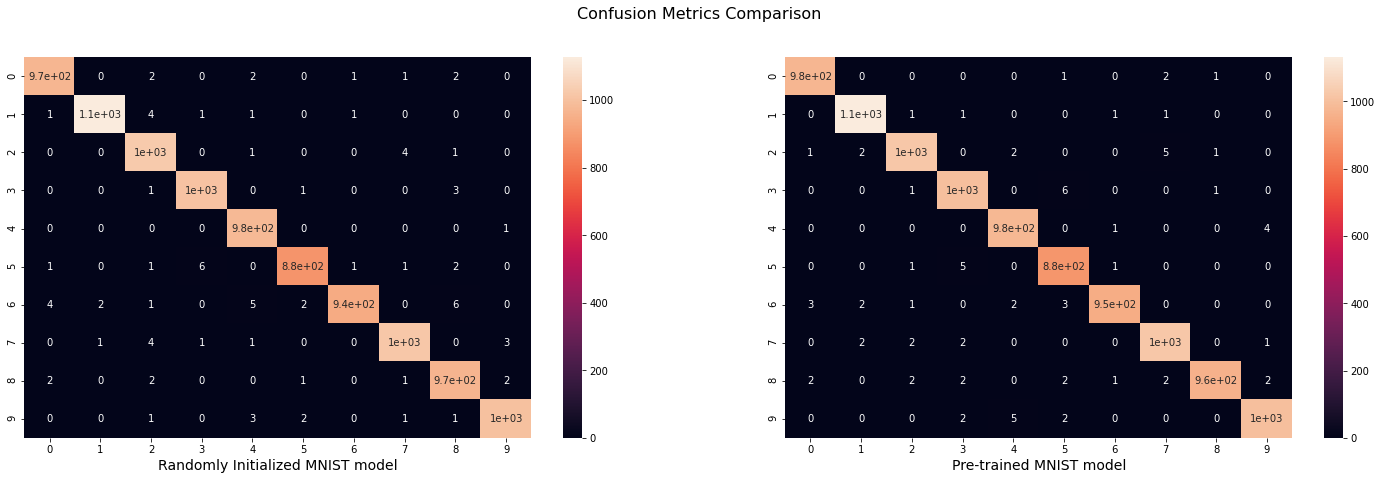

In [123]:

fig_cm = plt.figure(figsize=(25, 7))
fig_cm.suptitle('Confusion Metrics Comparison', fontsize = 16)
fig_cm.tight_layout()

fig_cm.add_subplot(121)
sns.heatmap(confusion_matrix(y_test, y_pred_randomized), annot = True)
plt.xlabel('Randomly Initialized MNIST model', fontsize = 14)

fig_cm.add_subplot(122)
sns.heatmap(confusion_matrix(y_test, y_pred_pretrained), annot = True)
plt.xlabel('Pre-trained MNIST model', fontsize = 14)

plt.show()



## Comparison using WANDB run log

In [136]:
'''
Instruction: Initialize everytime before using wandbcallback and run.join()
'''
# initialize wandb with the project

run = wandb.init(project = 'MNIST Training section 2',
                 config = {
                     "learning_rate": learning_rate,
                     "epochs": epochs,
                     "batch_size": train_generator.batch_size,
                     "loss_function": loss_fn,
                     "architecture": "CNN",
                     "dataset": 'Trainset'
                 })


In [135]:
model_mnist.load_weights(weights_file_randomized)

# based on final validation accuracy we are picking the model
val_loss, val_acc = model_mnist.evaluate(x_test_pro, y_test)

print('Run summary analysis using wandb for Randomly initialized MNIST model, whose convergence epoch number = 3')

# wandb log analysis
wandb.log({'Test error': round((1 - val_acc) * 100, 2)})

run.join()

313/313 [==============================] - 1s 2ms/step - loss: 0.0281 - acc: 0.9914
Run summary analysis using wandb for Randomly initialized MNIST model, whose convergence epoch number = 3


Test error,0.86
_runtime,15
_timestamp,1618002001
_step,0


Test error,▁
_runtime,▁
_timestamp,▁
_step,▁


In [137]:
model_mnist.load_weights(weights_file_pretrained)

# based on final validation accuracy we are picking the model
val_loss, val_acc = model_mnist.evaluate(x_test_pro, y_test)

print('Run summary analysis using wandb for Pretrained model, whose convergence epoch number = 7')

# wandb log analysis
wandb.log({'Test error': round((1 - val_acc) * 100, 2)})

run.join()

313/313 [==============================] - 1s 2ms/step - loss: 0.0262 - acc: 0.9921
Run summary analysis using wandb for Pretrained model, whose convergence epoch number = 7


Test error,0.79
_runtime,6
_timestamp,1618002014
_step,0


Test error,▁
_runtime,▁
_timestamp,▁
_step,▁


#### Analysis
* Test accuracy is higher in pre-trained model. 
* Response time is lesser in that pretrained one.
* Test error is less in Pretrained one.
Next we will proceed for GRADCAM testing for both the model to visualize some intuitive comparsion to show how model looks or pay attentions to sample images for classification

#### **Save MNIST model json file**

In [139]:
# saving MNIST model architecture as json
model_json = model.to_json()
with open("MNIST_model_final.json", "w") as json_file:
  json_file.write(model_json)